# Better Retrieval via "Embedding Retrieval"

> This tutorial is based on Haystack 1.x. If you're using Haystack 2.0 and would like to follow the updated version of this tutorial, check out [Creating Your First QA Pipeline with Retrieval-Augmentation](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline) and [Build an Extractive QA Pipeline](https://haystack.deepset.ai/tutorials/34_extractive_qa_pipeline).
>
> For more information on Haystack 2.0, read the [Haystack 2.0 announcement](https://haystack.deepset.ai/blog/haystack-2-release).

### Importance of Retrievers

The Retriever has a huge impact on the performance of our overall search pipeline.


### Different types of Retrievers
#### Sparse
Family of algorithms based on counting the occurrences of words (bag-of-words) resulting in very sparse vectors with length = vocab size.

**Examples**: BM25, TF-IDF

**Pros**: Simple, fast, well explainable

**Cons**: Relies on exact keyword matches between query and text


#### Dense
These retrievers use neural network models to create "dense" embedding vectors. Within this family, there are two different approaches:

a) Single encoder: Use a **single model** to embed both the query and the passage.
b) Dual-encoder: Use **two models**, one to embed the query and one to embed the passage.

**Examples**: REALM, DPR, Sentence-Transformers

**Pros**: Captures semantic similarity instead of "word matches" (for example, synonyms, related topics).

**Cons**: Computationally more heavy to use, initial training of the model (though this is less of an issue nowadays as many pre-trained models are available and most of the time, it's not needed to train the model).


### Embedding Retrieval

In this Tutorial, we use an `EmbeddingRetriever` with [Sentence Transformers](https://www.sbert.net/index.html) models.

These models are trained to embed similar sentences close to each other in a shared embedding space.

Some models have been fine-tuned on massive Information Retrieval data and can be used to retrieve documents based on a short query (for example, `multi-qa-mpnet-base-dot-v1`). There are others that are more suited to semantic similarity tasks where you are trying to find the most similar documents to a given document (for example, `all-mpnet-base-v2`). There are even models that are multilingual (for example, `paraphrase-multilingual-mpnet-base-v2`). For a good overview of different models with their evaluation metrics, see the [Pretrained Models](https://www.sbert.net/docs/pretrained_models.html#) in the Sentence Transformers documentation.



## Preparing the Colab Environment

- [Enable GPU Runtime](https://docs.haystack.deepset.ai/docs/enabling-gpu-acceleration#enabling-the-gpu-in-colab)


## Installing Haystack

To start, let's install the latest release of Haystack with `pip`:

In [7]:
%pip install --upgrade pip
%pip install haystack-ai accelerate sentence-transformers datasets

Note: you may need to restart the kernel to use updated packages.
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2024.2.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/510.5 kB ? eta -:--:--
   ------- -------------------------------- 92.2/510.5 kB 2.6 MB/s eta 0:00:01
   -------------------------------- ------- 409.6/510.5 kB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 510.5/510.5 kB 4.6 MB/s eta 0:00:00
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached fsspec-2024.2.0-py3-none-any.whl (170 kB)
   ---------------------------------------- 0.0/365.2 kB ? eta -:--:--
   --------------------------------------  358.4/365.2 kB 10.9 MB/s eta 0:00:01
   ---------------------------------------- 365.2/365.2 kB 7.6 MB/s eta 0:00:00
   ------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
"""!zip -r /content/custom_ner_model_with_bert.zip /content/custom_ner_model_with_bert
from google.colab import files
files.download("/content/custom_ner_model_with_bert.zip")"""

### Enabling Telemetry
Knowing you're using this tutorial helps us decide where to invest our efforts to build a better product but you can always opt out by commenting the following line. See [Telemetry](https://docs.haystack.deepset.ai/docs/telemetry) for more details.

In [ ]:
from haystack.telemetry import tutorial_running

tutorial_running(6)

## Logging

We configure how logging messages should be displayed and which log level should be used before importing Haystack.
Example log message:
INFO - haystack.utils.preprocessing -  Converting data/tutorial1/218_Olenna_Tyrell.txt
Default log level in basicConfig is WARNING so the explicit parameter is not necessary but can be changed easily:

In [ ]:
import json
import requests
import random

# Fetch book data from the URL
url = 'https://raw.githubusercontent.com/adibmenchali/bookworm/master/open_library_books.json'
response = requests.get(url)
books_data = response.json()

# Fetch questions from the URL
questions_url = 'https://raw.githubusercontent.com/adibmenchali/bookworm/master/questions.txt'
questions_response = requests.get(questions_url)
questions_lines = questions_response.text.strip().split('\n')

# Sample 10% of book titles
sampled_books = random.sample(books_data, k=int(0.10 * len(books_data)))

# Generate dataset
dataset = []

for book in sampled_books:
    title = book.get("title", "Unknown Title").lower()  # Convert title to lowercase
    for question_line in questions_lines:
        # Replace {title} with the lowercase book title
        question = question_line.format(title=title)
        # Create annotation for the question
        start_index = question.find(title)
        end_index = start_index + len(title)
        annotation = {"entities": [(start_index, end_index, "BOOK_TITLE")]}
        # Add annotated question and annotation to dataset
        dataset.append({"question": question, "annotation": annotation})

# Save dataset to JSON file
with open('annotated_dataset.json', 'w') as f:
    json.dump(dataset, f, indent=4)

print("Dataset generation complete.")


In [ ]:
import spacy
from spacy.training.example import Example
import json
from transformers import pipeline

# Load the BERT-based model from Hugging Face's Transformers library
nlp = pipeline("ner", model="distilbert-base-uncased", tokenizer="distilbert-base-uncased")

# Load the annotated dataset from a JSON file
def load_dataset_from_json(file_path):
    with open(file_path, 'r') as file:
        dataset = json.load(file)
    return dataset

# Convert annotations to SpaCy format
def convert_to_spacy_format(dataset):
    spacy_data = []
    for item in dataset:
        text = item['question'].lower()
        entities = item['annotation']['entities']
        spacy_entities = [(int(start), int(end), label) for start, end, label in entities]
        spacy_data.append((text, {"entities": spacy_entities}))
    return spacy_data

# Convert the annotated dataset to SpaCy format
def prepare_training_data(dataset):
    TRAIN_DATA = convert_to_spacy_format(dataset)
    return TRAIN_DATA

# Train the NER model
def train_ner_model(TRAIN_DATA):
    # Initialize a blank English model
    nlp_spacy = spacy.blank('en')

    # Add NER component to the pipeline
    ner = nlp_spacy.add_pipe('ner')

    # Add BOOK_TITLE as a new entity label
    ner.add_label('BOOK_TITLE')

    # Convert the SpaCy training data to Example objects
    examples = []
    for text, annotations in TRAIN_DATA:
        doc = nlp_spacy.make_doc(text)
        example = Example.from_dict(doc, annotations)
        examples.append(example)

    # Train the NER model
    nlp_spacy.begin_training()
    num_epochs = 10  # Number of training epochs
    print(f"Training the NER model for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        losses = {}
        for example in examples:
            nlp_spacy.update([example], drop=0.5, losses=losses)  # Adjust dropout as needed
        print("Losses:", losses)

    return nlp_spacy

# Save the trained model
def save_model(nlp_spacy, output_dir):
    nlp_spacy.to_disk(output_dir)

# Main function
def main():
    # Load the annotated dataset
    dataset = load_dataset_from_json('annotated_dataset.json')

    # Prepare the training data
    TRAIN_DATA = prepare_training_data(dataset)

    # Train the NER model
    nlp_spacy = train_ner_model(TRAIN_DATA)

    # Save the trained model (optional)
    save_model(nlp_spacy, "custom_ner_model_with_bert")

    print("Custom NER model trained and saved with BERT embeddings.")

if __name__ == "__main__":
    main()


In [ ]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

In [3]:
%pip uninstall -y farm-haystack haystack-ai
%pip install haystack-ai


Note: you may need to restart the kernel to use updated packages.


  Using cached haystack_ai-2.0.0-py3-none-any.whl.metadata (12 kB)
Using cached haystack_ai-2.0.0-py3-none-any.whl (265 kB)
Note: you may need to restart the kernel to use updated packages.


## Initializing the DocumentStore

FAISS is a library for efficient similarity search on a cluster of dense vectors.
The `FAISSDocumentStore` uses a SQL(SQLite in-memory be default) database under-the-hood
to store the document text and other meta data. The vector embeddings of the text are
indexed on a FAISS Index that later is queried for searching answers.
The default flavour of FAISSDocumentStore is "Flat" but can also be set to "HNSW" for
faster search at the expense of some accuracy. Just set the faiss_index_factor_str argument in the constructor.
For more info on which suits your use case: https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index

In [1]:
%pip install pymilvus

Note: you may need to restart the kernel to use updated packages.


In [23]:
%pip install -U milvus-haystack

  Using cached setuptools-69.2.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached argon2_cffi-23.1.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached argon2_cffi_bindings-21.2.0-cp36-abi3-win_amd64.whl.metadata (6.7 kB)
   ---------------------------------------- 0.0/189.7 kB ? eta -:--:--
   ------------------- -------------------- 92.2/189.7 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 189.7/189.7 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.7 MB ? eta -:--:--
    --------------------------------------- 0.1/3.7 MB 2.6 MB/s eta 0:00:02
   -- ------------------------------------- 0.2/3.7 MB 2.5 MB/s eta 0:00:02
   --- ------------------------------------ 0.3/3.7 MB 2.6 MB/s eta 0:00:02
   ----- ---------------------------------- 0.5/3.7 MB 2.9 MB/s eta 0:00:02
   ------- -------------------------------- 0.7/3.7 MB 3.0 MB/s eta 0:00:02
   --------- ------------------------------ 0.8/3.7 MB 3.2 MB/s eta 0:00:01
   ---------- ---------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
%pip install markdown-it-py mdit_plain

Note: you may need to restart the kernel to use updated packages.Collecting markdown-it-py
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
# Create the indexing Pipeline and index some documents
import glob
import os

from haystack import Pipeline
from haystack.components.converters import MarkdownToDocument
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter

from milvus_haystack import MilvusDocumentStore
from milvus_haystack.milvus_embedding_retriever import MilvusEmbeddingRetriever

file_paths = glob.glob("./milvus-document-store.md")

document_store = MilvusDocumentStore(
    connection_args={
        "host": "localhost",
        "port": "19530",
        "user": "",
        "password": "",
        "secure": False,
    },
    drop_old=True,
)
indexing_pipeline = Pipeline()
indexing_pipeline.add_component("converter", MarkdownToDocument())
indexing_pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=2))
indexing_pipeline.add_component("embedder", SentenceTransformersDocumentEmbedder())
indexing_pipeline.add_component("writer", DocumentWriter(document_store))
indexing_pipeline.connect("converter", "splitter")
indexing_pipeline.connect("splitter", "embedder")
indexing_pipeline.connect("embedder", "writer")
indexing_pipeline.run({"converter": {"sources": file_paths}})

print("Number of documents:", document_store.count_documents())

Converting markdown files to Documents: 0it [00:00, ?it/s]


Batches: 0it [00:00, ?it/s]

Number of documents: 0


In [2]:
%pip install ipywidgets

  Using cached ipywidgets-8.1.2-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.10-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.10-py3-none-any.whl.metadata (4.1 kB)
Using cached ipywidgets-8.1.2-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.10-py3-none-any.whl (215 kB)
Using cached widgetsnbextension-4.0.10-py3-none-any.whl (2.3 MB)
Note: you may need to restart the kernel to use updated packages.


### Option 2: Milvus

> As of version 1.15, MilvusDocumentStore has been deprecated in Haystack. It is deleted from the haystack repository as of version 1.17 and moved to [haystack-extras](https://github.com/deepset-ai/haystack-extras/tree/main). For more details, check out [Deprecation of MilvusDocumentStore](https://github.com/deepset-ai/haystack/discussions/4785).

Milvus is an open source database library that is also optimized for vector similarity searches like FAISS.
Like FAISS it has both a "Flat" and "HNSW" mode but it outperforms FAISS when it comes to dynamic data management.
It does require a little more setup, however, as it is run through Docker and requires the setup of some config files.
See [their docs](https://milvus.io/docs/v1.0.0/milvus_docker-cpu.md) for more details.

In [ ]:
# Milvus cannot be run on Colab, so this cell is commented out.
# To run Milvus you need Docker (versions below 2.0.0) or a docker-compose (versions >= 2.0.0), neither of which is available on Colab.
# See Milvus' documentation for more details: https://milvus.io/docs/install_standalone-docker.md

# !pip install farm-haystack[milvus]==1.16.1

# from haystack.utils import launch_milvus
# from haystack.document_stores import MilvusDocumentStore

# launch_milvus()
# document_store = MilvusDocumentStore()

## Cleaning and Writing Documents

Similarly to the previous tutorials, we download, convert and write some Game of Thrones articles to our DocumentStore.

In [ ]:
"""from haystack.utils import clean_wiki_text, convert_files_to_docs, fetch_archive_from_http


# Let's first get some files that we want to use
doc_dir = "data/tutorial6"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/wiki_gameofthrones_txt6.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

# Convert files to dicts
docs = convert_files_to_docs(dir_path=doc_dir, clean_func=clean_wiki_text, split_paragraphs=True)

# Now, let's write the dicts containing documents to our DB.
document_store.write_documents(docs)"""

Import data from Google Books API

In [5]:
%pip install spacy


  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.2-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.3.4-py3-none-any.whl.metadata (4.7 kB)
  Using cached smart_open-6.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached confection-0.1.4-py3-none-any.whl.metadata (19 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached cloudpathlib-0.16.0-py3-none-any.whl.metadata (14 kB)
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.1 MB 3.2 MB/s eta 0:00:04
    --------------------------------------- 0.2/12.1 MB 2.3 MB/s eta 0:00:06
    --------------------------------------- 0.3/12.1 MB 2.3 MB/s eta 0:00:06
   - -------------------------------------- 0.4/12.1 MB 2.3 MB/s eta 0:00:06
   - -------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [46]:
import requests
from haystack import Document
from transformers import pipeline
import random
import csv



# Function to fetch book data from Google Books API
def fetch_book_data(book_title):
    api_url = f"https://www.googleapis.com/books/v1/volumes?q={book_title}&maxResults=3&langRestrict=en&printType=books"
    response = requests.get(api_url)
    if response.status_code == 200:
        book_data = response.json()
        if "items" in book_data:
            return book_data["items"]
    return None


# List of preset book titles
titles = []

# Read the CSV file and extract the "title" field
with open('bestsellers.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        titles.append(row['title'])

# Sample 500 unique titles without duplicates
sampled_titles = []
while len(sampled_titles) < 5:
    sampled_title = random.choice(titles)
    if sampled_title not in sampled_titles:
        sampled_titles.append(sampled_title)
        
documents = []  # List to store all documents

# Iterate over the sampled titles
for book_title in sampled_titles:
    # Fetch book data from Google Books API
    book_items = fetch_book_data(book_title)
    if book_items:
        # Create Document objects for each book item and aggregate descriptions
        descriptions = []  # List to aggregate descriptions from all items
        for item in book_items:
            meta = item.get("volumeInfo", {})
            
            # Ensure all keys are present and set their value to "Not available" if missing
            all_keys = ['title', 'subtitle', 'authors', 'publisher', 'publishedDate', 'description',
                        'industryIdentifiers', 'readingModes', 'pageCount', 'printType', 'categories',
                        'averageRating', 'ratingsCount', 'maturityRating', 'allowAnonLogging', 
                        'contentVersion', 'panelizationSummary', 'imageLinks', 'language', 
                        'previewLink', 'infoLink', 'canonicalVolumeLink', 'seriesInfo']
            for key in all_keys:
                if key not in meta:
                    meta[key] = "Not available"
                elif isinstance(meta[key], list):
                    # Convert each item in the list to string
                    meta[key] = ", ".join(str(item) for item in meta[key])

            content = str(meta)  # Convert metadata to string for content
            # Convert all values in the meta dictionary to strings
            for key, value in meta.items():
                meta[key] = str(value)
            document = Document(content=content, meta=meta)
            documents.append(document)
            # Add description to descriptions list if available
            if "description" in meta:
                descriptions.append(meta["description"])
                
model = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
print("__   __ _ ")
indexing_pipeline = Pipeline()

indexing_pipeline.add_component(instance=SentenceTransformersDocumentEmbedder(model=model), name="embedder")
indexing_pipeline.add_component(instance=DocumentWriter(document_store=document_store), name="writer")
indexing_pipeline.connect("embedder.documents", "writer.documents")

indexing_pipeline.run({"documents": documents})

__   __ _ 


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

{'writer': {'documents_written': 76}}

In [39]:
print("Number of documents:", document_store.count_documents())

Number of documents: 23


In [47]:
documents

[Document(id=74f675d22771c9c5a07298691038b89d80e8c3dcf5559911f40ea341e0263e38, content: '{'title': 'Teaching K-8 Reading', 'subtitle': 'Disrupting 10 Literacy Myths', 'authors': ['Christine...', meta: {'title': 'Teaching K-8 Reading', 'subtitle': 'Disrupting 10 Literacy Myths', 'authors': "['Christine H. Leland', 'Mitzi Lewison', 'Jerome C. Harste']", 'publisher': 'Routledge', 'publishedDate': '2020-10-10', 'description': 'Accessible and engaging, this methods textbook provides a roadmap for improving reading instruction. Leland, Lewison, and Harste explain why certain ineffective or debunked literacy techniques prevail in the classroom, identify the problematic assumptions that underly these popular myths, and offer better alternatives for literacy teaching. Grounded in a mantra that promotes critical thinking and agency—Enjoy! Dig Deeply! Take Action!—this book presents a clear framework, methods, and easy applications for designing and implementing effective literacy instruction. Nu

In [52]:
from haystack import Pipeline

from milvus_haystack.milvus_embedding_retriever import MilvusEmbeddingRetriever
# Create the retrieval pipeline and try a query
question = "Who wrote Money master the game?"

"""retrieval_pipeline = Pipeline()
retrieval_pipeline.add_component("embedder", SentenceTransformersTextEmbedder())
retrieval_pipeline.add_component("retriever", MilvusEmbeddingRetriever(document_store=document_store, top_k=3))"""
retriever = MilvusEmbeddingRetriever(document_store=document_store)

reader = ExtractiveReader()
reader.warm_up()
extractive_qa_pipeline = Pipeline()
extractive_qa_pipeline.add_component(instance=SentenceTransformersTextEmbedder(model=model), name="embedder")
extractive_qa_pipeline.add_component(instance=retriever, name="retriever")
extractive_qa_pipeline.add_component(instance=reader, name="reader")

extractive_qa_pipeline.connect("embedder.embedding", "retriever.query_embedding")
extractive_qa_pipeline.connect("retriever.documents", "reader.documents")

extractive_qa_pipeline.run(
    data={"embedder": {"text": question}, "retriever": {"top_k": 3}, "reader": {"query": question, "top_k": 2}}
)

ValueError: Input top_k not found in component retriever.

In [43]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersTextEmbedder

retriever = InMemoryEmbeddingRetriever(document_store=document_store)
reader = ExtractiveReader()
reader.warm_up()

extractive_qa_pipeline = Pipeline()

extractive_qa_pipeline.add_component(instance=SentenceTransformersTextEmbedder(model=model), name="embedder")
extractive_qa_pipeline.add_component(instance=retriever, name="retriever")
extractive_qa_pipeline.add_component(instance=reader, name="reader")

extractive_qa_pipeline.connect("embedder.embedding", "retriever.query_embedding")
extractive_qa_pipeline.connect("retriever.documents", "reader.documents")

ValueError: document_store must be an instance of InMemoryDocumentStore

In [41]:
query = "who wrote Teaching K-8 Reading?"
extractive_qa_pipeline.run(
    data={"embedder": {"text": query}, "retriever": {"top_k": 3}, "reader": {"query": query, "top_k": 2}}
)

NameError: name 'extractive_qa_pipeline' is not defined

In [18]:
%pip install fuzzywuzzy
%pip install python-Levenshtein

Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


Running retrieval model:
* Initializes NER model to detect book titles
* Checks if book title exists in document_store (similarity 90)
    - if yes: retrieves answer from document_store directly
    - else: queries google books api then adds info to the document_store and retrieves it
 

In [6]:
import requests
from haystack.utils import clean_wiki_text
from haystack.schema import Document
import spacy
from transformers import pipeline
from fuzzywuzzy import process
from haystack.utils import print_answers



# Load the NER model
nlp = spacy.load("custom_ner_model_with_bert")

# Function to fetch book data from Google Books API
def fetch_book_data(book_title):
    api_url = f"https://www.googleapis.com/books/v1/volumes?q={book_title}&maxResults=3&langRestrict='en'&printType=books"
    response = requests.get(api_url)
    if response.status_code == 200:
        book_data = response.json()
        if "items" in book_data:
            return book_data["items"]
    return None

# Function to extract book title from user input using NER
def extract_book_title(question):
    entities = nlp(question)
    for ent in entities.ents:  # Iterate over recognized entities
        if ent.label_ == 'BOOK_TITLE':  # Check if the entity is a book title
            return ent.text
    return None

# Prompt user for a question about a book
user_question = input("Ask a question about a book: ")

# Extract book title from user input
book_title = extract_book_title(user_question)

if book_title:
    # Check if the book title matches any titles in the list using fuzzy matching
    matched_title, similarity_score = process.extractOne(book_title, sampled_titles)
    if similarity_score >= 90:  # Adjust the threshold as needed
        # Book title matched, retrieve information from the document store
        print(f"Book title matched: {matched_title}")
        prediction = pipe.run(query=user_question, params={"Retriever": {"top_k": 3}, "Reader": {"top_k": 1}})
        answers = print_answers(prediction, details="minimum")

    else:
        book_items = fetch_book_data(book_title)
        documents = []
        descriptions = []  # List to aggregate descriptions from all items
        for item in book_items:
            meta = item.get("volumeInfo", {})
            content = str(meta)  # Convert metadata to string for content
            document = Document(content=content, meta=meta)
            documents.append(document)
            # Add description to descriptions list if available
            if "description" in meta:
                descriptions.append(meta["description"])

        # Concatenate all descriptions into one document
        concatenated_descriptions = "\n".join(descriptions)
        all_descriptions_doc = Document(content=concatenated_descriptions, meta={"book_title": book_title})

        # Write individual item documents and the aggregated descriptions document to the document store
        document_store.write_documents(documents + [all_descriptions_doc])
        temp_document_store = InMemoryDocumentStore()
        temp_document_store.write_documents(documents + [all_descriptions_doc])
        temp_document_store.update_embeddings(retriever)
        prediction = pipe.run(query=user_question, params={"Retriever": {"top_k": 3}, "Reader": {"top_k": 1}})
        print_answers(prediction, details="minimum")
        print(f"{len(documents) + 1} documents written to the document store.")  # Including the aggregated descriptions document
else:
    print("Book data not found.")


ImportError: cannot import name 'clean_wiki_text' from 'haystack' (c:\Users\Adib\AppData\Local\Programs\Python\Python310\lib\site-packages\haystack\__init__.py)

In [5]:
# Create a temporary in-memory document store
from haystack.document_stores.in_memory import InMemoryDocumentStore

temp_document_store = InMemoryDocumentStore()

# Add documents to the temporary document store
temp_document_store.write_documents(documents)

# Initialize a temporary retriever using the temporary document store
temp_retriever = EmbeddingRetriever(document_store=temp_document_store, embedding_model="your_embedding_model")

# Update embeddings for specific documents in the temporary document store
temp_document_store.update_embeddings(temp_retriever, update_existing_embeddings=False)


NameError: name 'documents' is not defined

In [10]:
import requests
from haystack import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
import spacy
from transformers import pipeline

# Load the NER model
nlp = spacy.load("custom_ner_model_with_bert")

# Function to fetch book data from Google Books API
def fetch_book_data(book_title):
    api_url = f"https://www.googleapis.com/books/v1/volumes?q={book_title}&maxResults=3&langRestrict='en'&printType=books"
    response = requests.get(api_url)
    if response.status_code == 200:
        book_data = response.json()
        if "items" in book_data:
            return book_data["items"]
    return None

# Function to extract book title from user input using NER
def extract_book_title(question):
    entities = nlp(question)
    for ent in entities.ents:  # Iterate over recognized entities
        if ent.label_ == 'BOOK_TITLE':  # Check if the entity is a book title
            return ent.text
    return None


# Prompt user for a question about a book
user_question = input("Ask a question about a book: ")

# Extract book title from user input
book_title = extract_book_title(user_question)

if book_title:
    # Fetch book data from Google Books API
    book_items = fetch_book_data(book_title)

    if book_items:
        # Create Document objects for each book item and aggregate descriptions
        documents = []
        descriptions = []  # List to aggregate descriptions from all items
        for item in book_items:
            meta = item.get("volumeInfo", {})
            content = str(meta)  # Convert metadata to string for content
            document = Document(content=content, meta=meta)
            documents.append(document)
            # Add description to descriptions list if available
            if "description" in meta:
                descriptions.append(meta["description"])

        # Concatenate all descriptions into one document
        concatenated_descriptions = "\n".join(descriptions)
        all_descriptions_doc = Document(content=concatenated_descriptions, meta={"book_title": book_title})

        # Write individual item documents and the aggregated descriptions document to the document store
        document_store = InMemoryDocumentStore()

        document_store.write_documents(documents + [all_descriptions_doc])

        print(f"{len(documents) + 1} documents written to the document store.")  # Including the aggregated descriptions document
    else:
        print("Book data not found.")
else:
    print("Book title not found in the question.")


4 documents written to the document store.


In [13]:
from haystack import Pipeline

model = "sentence-transformers/multi-qa-mpnet-base-dot-v1"

document_store = InMemoryDocumentStore()

indexing_pipeline = Pipeline()

indexing_pipeline.add_component(instance=SentenceTransformersDocumentEmbedder(model=model), name="embedder")
indexing_pipeline.add_component(instance=DocumentWriter(document_store=document_store), name="writer")
indexing_pipeline.connect("embedder.documents", "writer.documents")

indexing_pipeline.run({"documents": documents})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'writer': {'documents_written': 3}}

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

c:\Users\Adib\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Adib\.cache\huggingface\hub\models--deepset--roberta-base-squad2-distilled. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

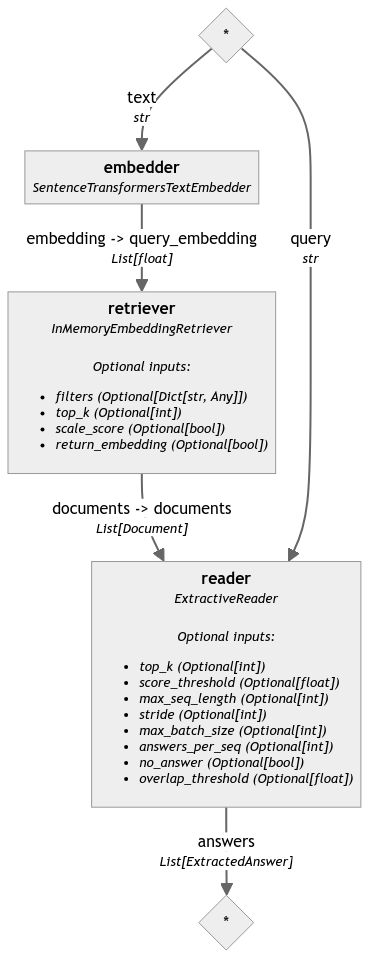

In [15]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersTextEmbedder


retriever = InMemoryEmbeddingRetriever(document_store=document_store)
reader = ExtractiveReader()
reader.warm_up()

extractive_qa_pipeline = Pipeline()

extractive_qa_pipeline.add_component(instance=SentenceTransformersTextEmbedder(model=model), name="embedder")
extractive_qa_pipeline.add_component(instance=retriever, name="retriever")
extractive_qa_pipeline.add_component(instance=reader, name="reader")

extractive_qa_pipeline.connect("embedder.embedding", "retriever.query_embedding")
extractive_qa_pipeline.connect("retriever.documents", "reader.documents")

In [16]:
extractive_qa_pipeline.run(
    data={"embedder": {"text": user_question}, "retriever": {"top_k": 3}, "reader": {"query": user_question, "top_k": 2}}
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'reader': {'answers': [ExtractedAnswer(query='who is the author of anxious people?', score=0.7182126641273499, data='Fredrik Backman', document=Document(id=330348e644b213ce1e2591168b4d935006e3b490eb557e8354125ac2559e80bb, content: '{'title': 'Anxious People', 'subtitle': 'A Novel', 'authors': ['Fredrik Backman'], 'publisher': 'Sim...', meta: {'title': 'Anxious People', 'subtitle': 'A Novel', 'authors': ['Fredrik Backman'], 'publisher': 'Simon and Schuster', 'publishedDate': '2021-07-06', 'description': 'Taken hostage by a failed bank robber while attending an open house, eight anxiety-prone strangers--including a redemption-seeking bank director, two couples who would fix their marriages, and a plucky octogenarian--discover their unexpected common traits.', 'industryIdentifiers': [{'type': 'ISBN_13', 'identifier': '9781501160844'}, {'type': 'ISBN_10', 'identifier': '1501160842'}], 'readingModes': {'text': False, 'image': False}, 'pageCount': 352, 'printType': 'BOOK', 'categories': ['F

In [45]:
book_items

[{'kind': 'books#volume',
  'id': 'NUK2DwAAQBAJ',
  'etag': 'PWYkvRoj7E0',
  'selfLink': 'https://www.googleapis.com/books/v1/volumes/NUK2DwAAQBAJ',
  'volumeInfo': {'title': 'The Wonderful Things You Will Be',
   'authors': ['Emily Winfield Martin'],
   'publisher': 'Penguin UK',
   'publishedDate': '2020-08-06',
   'description': '"This is the first time / There\'s ever been you, / So I wonder what wonderful things / You will do." In this timeless poem about growing up, Emily Windfield Martin explores all the things you can choose to be, from brave and bold to creative and wise. Filled with beautiful, quirky illustrations and clever rhyme, grown-ups will love reading this book to their children at any age, as they lovingly consider all the possibilities that lie ahead. Its enduring message of love and acceptance as children grow and change is both universal and poignant, and it one to share over and over again.',
   'industryIdentifiers': [{'type': 'ISBN_13', 'identifier': '978024144

## Initializing the Retriever

**Here:** We use an `EmbeddingRetriever`.

**Alternatives:**

- `BM25Retriever` with custom queries (for example, boosting) and filters
- `DensePassageRetriever` which uses two encoder models, one to embed the query and one to embed the passage, and then compares the embedding for retrieval
- `TfidfRetriever` in combination with a SQL or InMemory DocumentStore for simple prototyping and debugging

In [6]:
from haystack.nodes import EmbeddingRetriever

retriever = EmbeddingRetriever(
    document_store=document_store, embedding_model="sentence-transformers/multi-qa-mpnet-base-dot-v1"
)
# Important:
# Now that we initialized the Retriever, we need to call update_embeddings() to iterate over all
# previously indexed documents and update their embedding representation.
# While this can be a time consuming operation (depending on the corpus size), it only needs to be done once.
# At query time, we only need to embed the query and compare it to the existing document embeddings, which is very fast.
# document_store.update_embeddings(retriever)

## Initializing the Reader

Similar to previous tutorials we now initalize our Reader.

Here we use a FARMReader with the [*deepset/roberta-base-squad2*](https://huggingface.co/deepset/roberta-base-squad2) model.

In [7]:
from haystack.nodes import FARMReader

reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)

## Initializing the Pipeline

With a Haystack `Pipeline` you can stick together your building blocks to a search pipeline.
Under the hood, `Pipelines` are Directed Acyclic Graphs (DAGs) that you can easily customize for your own use cases.
To speed things up, Haystack also comes with a few predefined Pipelines. One of them is the `ExtractiveQAPipeline` that combines a retriever and a reader to answer our questions.
You can learn more about `Pipelines` in the [docs](https://docs.haystack.deepset.ai/docs/pipelines).

In [8]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, retriever)

## Asking a Question

We use the pipeline `run()` method to ask a question. With the `run()` method, you can configure how many candidates the Reader and Retriever shall return. The higher top_k for Retriever, the better (but also the slower) your answers.

In [9]:
prediction = pipe.run(
    query=user_question, params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 1}}
)
from haystack.utils import print_answers


print_answers(prediction, details="minimum")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

'Query: who wrote anxious people?'
'Answers:'
[]


In [ ]:
from haystack.utils import print_answers


print_answers(prediction, details="minimum")

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Function to generate response using GPT model
def generate_response(question, answer):
    # Construct a prompt that includes the question and instructs the model to generate a simple reply based on both the question and the answer
    prompt = f"Question: {question}\nAnswer: {answer}\nGenerate a simple reply based on the question and the answer."

    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    # Generate response
    output_ids = model.generate(input_ids, max_length=100, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)

    # Decode the response
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return response

# Example usage
question = "How many pages are in the book?"
answer = "511"
response = generate_response(question, answer)
print(response)
